###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Mesh generation by Transfinite Interpolation applied to the sea dike problem

We have implemented and tested our mesh generation approach using Transfinite Interpolation (TFI) in the previous lesson. Now, let's apply it to the problem of the sea dike with strong topography.

## Revisiting the sea dike problem

To generate a deformed quad mesh incorporating the strong topography of the sea dike, we only have to describe the topography by a parametrized curve. We can roughly describe it by the following equations:

* $x = 0\; m - 4\; m\; \rightarrow\; z(x) = 0\; m$
* $x = 4\; m - 18.5\; m\; \rightarrow\; z(x) = \frac{6.76}{14.5}(x-4)\; m$
* $x = 18.5\; m - 22.5\; m\; \rightarrow\; z(x) = 6.76\; m$
* $x = 22.5\; m - 44.17\; m\; \rightarrow\; z(x) = -\frac{3.82}{21.67}(x-22.5)\; m$

This might be a little bit rough approximation, because photos of the data acquisition show a smooth transition between the tilted and horizontal surfaces of the dike. Nevertheless, let's try to generate a mesh for this topography model.

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# Get rid of a Matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define number of grid points in x-direction and spatial vectors
NXtopo = 100
x_dike = np.linspace(0.0, 61.465, num=NXtopo)
z_dike = np.zeros(NXtopo)

# calculate dike topograpy
def dike_topo(x_dike, z_dike, NX1):
    
    for i in range(NX1):

        if(x_dike[i]<4.0):
            z_dike[i] = 0.0
        
        if(x_dike[i]>=4.0 and x_dike[i]<18.5):
            z_dike[i] = (x_dike[i]-4) * 6.76/14.5
        
        if(x_dike[i]>=18.5 and x_dike[i]<22.5):
            z_dike[i] = 6.76
    
        if(x_dike[i]>=22.5 and x_dike[i]<x_dike[-1]):
            z_dike[i] = -(x_dike[i]-22.5) * 3.82/21.67 + 6.76
            
    return x_dike, z_dike

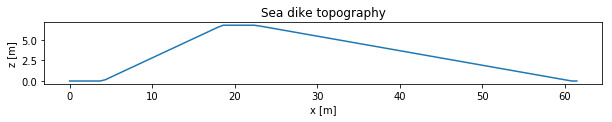

In [4]:
# Define figure size
rcParams['figure.figsize'] = 10, 7

# Plot sea dike topography
dike_topo(x_dike,z_dike,NXtopo)
plt.plot(x_dike,z_dike)
plt.title("Sea dike topography" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')

Unfortunately, the TFI is defined on the unit square, so we have to normalize the sea dike topography, before applying the TFI. 

In [5]:
# Normalize sea dike topography
xmax_dike = np.max(x_dike)
zmax_dike = np.max(z_dike)

x_dike_norm = x_dike / xmax_dike
z_dike_norm = z_dike / zmax_dike + 1

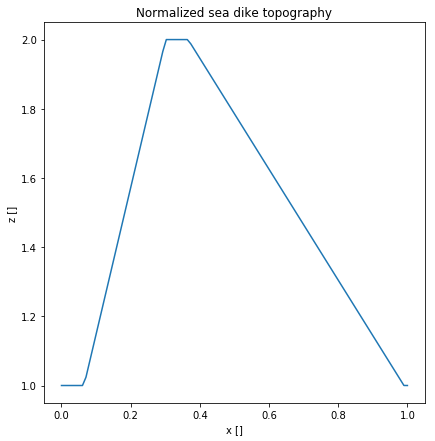

In [6]:
# Plot normalized sea dike topography
plt.plot(x_dike_norm,z_dike_norm)
plt.title("Normalized sea dike topography" )
plt.xlabel("x []")
plt.ylabel("z []")
plt.axes().set_aspect('equal')

OK, now we have the normalized dike topography on a unit square, so we can define the parametric curve for the topography.

In [7]:
# Define parameters for deformed Cartesian mesh
NX = 80
NZ = 20

In [8]:
# Define parametric curves at model boundaries ...
# ... bottom boundary
def Xb(s):
    
    x = s
    z = 0.0

    xzb = [x,z]
    
    return xzb

# ... top boundary
def Xt(s):
    
    x = s
    
    # normalized x-coordinate s -> unnormalized x-coordinate x_d
    x_d = xmax_dike * s
    z_d = 0.0
    
    if(x_d<4.0):
        z_d = 0.0
        
    if(x_d>=4.0 and x_d<18.5):
        z_d = (x_d-4) * 6.76/14.5
        
    if(x_d>=18.5 and x_d<22.5):
        z_d = 6.76
    
    if(x_d>=22.5 and x_d<xmax_dike):
        z_d = -(x_d-22.5) * 3.82/21.67 + 6.76
    
    # unnormalized z-coordinate z_d -> normalized z-coordinate z
    z = z_d / zmax_dike + 1

    xzt = [x,z]
    
    return xzt

# ... left boundary
def Xl(s):
    
    x = 0.0
    z = s  

    xzl = [x,z]
    
    return xzl

# ... right boundary
def Xr(s):
    
    x = 1
    z = s
    
    xzr = [x,z]
    
    return xzr

In [9]:
# Transfinite interpolation

# Discretize along xi and eta axis
xi = np.linspace(0.0, 1.0, num=NX)
eta = np.linspace(0.0, 1.0, num=NZ)

xi1, eta1 = np.meshgrid(xi, eta)

# Intialize matrices for x and z axis
X = np.zeros((NX,NZ))
Z = np.zeros((NX,NZ))

# loop over cells
for i in range(NX):
    Xi = xi[i]
    for j in range(NZ):
        Eta = eta[j]
        
        xb = Xb(Xi)
        xb0 = Xb(0)
        xb1 = Xb(1)
        
        xt = Xt(Xi)
        xt0 = Xt(0)
        xt1 = Xt(1)
        
        xl = Xl(Eta)
        xr = Xr(Eta)

        # Transfinite Interpolation (Gordon-Hall algorithm)
        X[i,j] = (1-Eta) * xb[0] + Eta * xt[0] + (1-Xi) * xl[0] + Xi * xr[0] \
               - (Xi * Eta * xt1[0] + Xi * (1-Eta) * xb1[0] + Eta * (1-Xi) * xt0[0] \
               + (1-Xi) * (1-Eta) * xb0[0])
            
        Z[i,j] = (1-Eta) * xb[1] + Eta * xt[1] + (1-Xi) * xl[1] + Xi * xr[1] \
               - (Xi * Eta * xt1[1] + Xi * (1-Eta) * xb1[1] + Eta * (1-Xi) * xt0[1] \
               + (1-Xi) * (1-Eta) * xb0[1])        

No error so far. Before plotting the generated mesh, we have to unnormalize the spatial coordinates.

In [10]:
# Unnormalize the mesh 
X = X * xmax_dike
Z = Z * zmax_dike

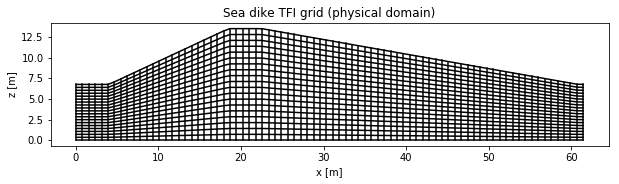

In [11]:
# Plot TFI mesh (physical domain)
plt.plot(X, Z, 'k')
plt.plot(X.T, Z.T, 'k')

plt.title("Sea dike TFI grid (physical domain)" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')
plt.savefig('sea_dike_TFI.pdf', bbox_inches='tight', format='pdf')
plt.show()

Finally, we have a deformed quad mesh for the sea dike problem, representing the strong surface topography quite well.

## We learned:

* How to generate a deformed quad mesh by transfinite interpolation for a sea dike topography
* Quad mesh generation is quite time-consuming, even for simple model geometries
* What Post-Docs do in their free-time